https://github.com/qubvel/segmentation_models

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-fw5frdzn
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-fw5frdzn
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-u1onhqoe/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models


Get the data sets

In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from skimage import img_as_float

Load the model

In [0]:
from keras.models import load_model
from keras.models import Model
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

In [0]:
# load model
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load the model
model = load_model(r'/content/drive/My Drive/Colab Notebooks/models/segmentation/mole_seg.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
# get our images to be segmented
img_pth = r'/content/drive/My Drive/Colab Notebooks/datasets/processed/resized.npy'
meta_pth = r'/content/drive/My Drive/Colab Notebooks/datasets/HAM10000_metadata.csv'
img_lst = pd.read_csv(meta_pth)['image_id'] + '.jpg'

# get the image array
images = np.load(img_pth)

array(['ISIC_0032162.jpg', 'ISIC_0030346.jpg', 'ISIC_0031444.jpg',
       'ISIC_0027517.jpg', 'ISIC_0034145.jpg', 'ISIC_0030818.jpg',
       'ISIC_0026838.jpg', 'ISIC_0031563.jpg', 'ISIC_0026350.jpg',
       'ISIC_0024465.jpg'], dtype=object)

In [0]:
# predict segmentation
prediction = model.predict(img_as_float(images), verbose=1)

# threshold at 0.5
prediction[prediction >= 0.5] = 1.0
prediction[prediction < 0.5] = 0.0

# segment the images
segmented = images.copy()
segmented[prediction[:, :, :, 0]==0, :] = 0

# # get the layer before the sigmoid function
# layer_name = 'final_conv'
# intermediate_layer_model = Model(inputs=model.input,
#                                  outputs=model.get_layer(layer_name).output)
# intermediate_output = intermediate_layer_model.predict(to_test)

10015/10015 [==============================] - 1210s 121ms/step


The result of UNet is semantic segmentation - which means that UNet indiscriminantly identifies all lesions in the given sample. We need to apply some post-processing to the results to convert this to a single blob in the middle.

https://arxiv.org/pdf/1807.08844.pdf

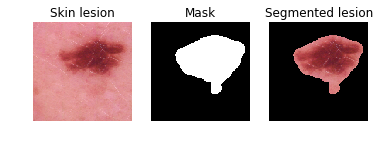

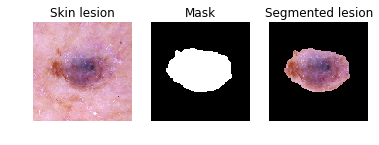

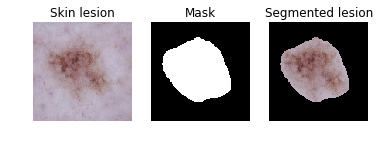

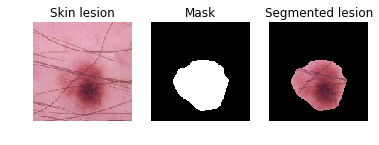

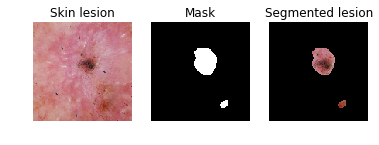

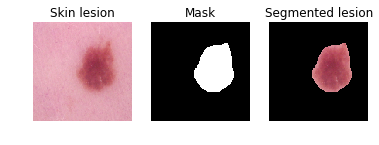

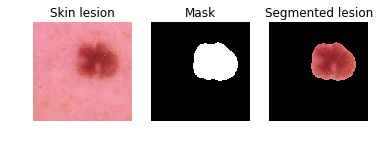

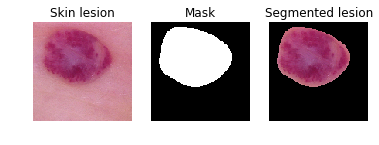

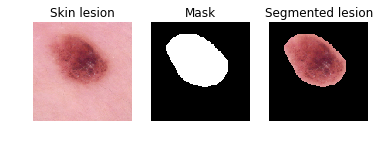

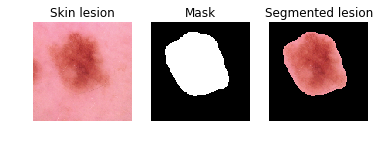

In [0]:
for idx in np.random.randint(0, images.shape[0], 10):
    fig, axes = plt.subplots(1, 3)
    ax = axes.flatten()
  
    # original image
    ax[0].imshow(images[idx, :, :, :])
    ax[0].set_axis_off()
    ax[0].set_title('Skin lesion')
  
    # our base prediction
    ax[1].imshow(prediction[idx, :, :, 0], cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title('Mask')
  
    # masked lesion
    ax[2].imshow(segmented[idx, :, :, :])
    ax[2].set_axis_off()
    ax[2].set_title('Segmented lesion')

Now lets process all of the images:

In [0]:
# # where to dump our segmented images and non-segmented images (resized)
# pro_pth = r'/content/drive/My Drive/Colab Notebooks/datasets/processed'
# ensure_dir(pro_pth)
# rsz_pth = r'/content/drive/My Drive/Colab Notebooks/datasets/processed/resized'
# ensure_dir(rsz_pth)
# seg_pth = r'/content/drive/My Drive/Colab Notebooks/datasets/processed/segmented'
# ensure_dir(seg_pth)

# segmented = images.copy()
# segmented[prediction[:, :, :, 0]==0, :] = 0

# # get the fnm, img and prediction
# for i in range(len(img_lst)):
#   fnm = img_lst[i]
#   img = images[i, :, :, :]
#   seg = segmented[i, :, :, :]
  
#   # convert arrays back to PIL images
#   pil_img = Image.fromarray(img)
#   pil_seg = Image.fromarray(seg)
  
#   # save in the new folder
#   pil_img.save(os.path.join(rsz_pth, fnm))
#   pil_seg.save(os.path.join(seg_pth, os.path.splitext(fnm)[0] + '_seg.jpg'))
  
#   if i % 500 == 0:
#     print('{:.0%}'.format(i/float(len(img_lst))), end=', ')
    
# save as numpy arrays
np.save(r'/content/drive/My Drive/Colab Notebooks/datasets/ProcessedImages/segmented.npy', segmented) 

In [0]:
segmented.shape

(10015, 128, 128, 3)